## **<h1 align="center"> Time-Series analysis _ Oil Index</h1>**


## Table of Contents
* [1 - Packages](#1)
* [2 - Load Data](#2)
* [3 - Data Preparation](#3)
* [4 - Data visualization](#4)
* [5 - Statitstical tests](#5)

    * [5-1 Run the augmented Dickey-Fuller Test to confirm stationarity](#ex-1)
    * [5 - 2 Run the ACF and PACF plots](#ex-2)

* [6 - Time-series Models](#6)
    * [6 -1 SARIMAX - Seasonal Autoregressive Integrated Moving Average Exogenou](#ex-3)
    * [6 - 2 Time-Series Prediction Using RNN - LSTM](#ex-4)
    * [6 - 3 Prophet Model](#ex-5)


<a name='1'></a>
## 1 - Packages
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from numpy.random import seed
seed(2)

##### Load specific forecasting tools

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from statsmodels.tools.eval_measures import rmse
from pmdarima import auto_arima                              # for determining ARIMA orders

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.tools import diff

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
from tensorflow.keras.optimizers import SGD

tf.random.set_seed(3)

import pandas as pd
from fbprophet import Prophet

import warnings
warnings.filterwarnings("ignore")

<a name='2'></a>
## 2 - Load Data
----

In [2]:
db = pd.read_excel("external-data-indices-onlyfebruary.xls")
df = db[["Commodity", "POILAPSP"]].iloc[-121:]
df.head()

,Commodity,POILAPSP
267,2012M1,225.891156
268,2012M2,236.120545
269,2012M3,248.161237
270,2012M4,239.28053
271,2012M5,220.830698


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 267 to 387
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Commodity  121 non-null    object
 1   POILAPSP   121 non-null    object
dtypes: object(2)
memory usage: 2.0+ KB


<a name='3'></a>
## 3 - Data Preparation
---

In [4]:
df['Oil_index'] = df['POILAPSP'].astype('float')
df['Commodity'] = df['Commodity'].str.replace("M", "-") + '-1'
df['Date'] = pd.to_datetime(df['Commodity'])
df = df[['Date', 'Oil_index']]
df.set_index('Date',inplace=True)
df.index.freq = 'MS'
df.head()

,Oil_index
Date,
2012-01-01,225.891156
2012-02-01,236.120545
2012-03-01,248.161237
2012-04-01,239.280530
2012-05-01,220.830698


<a name='4'></a>
## 4 - Data visualization
----

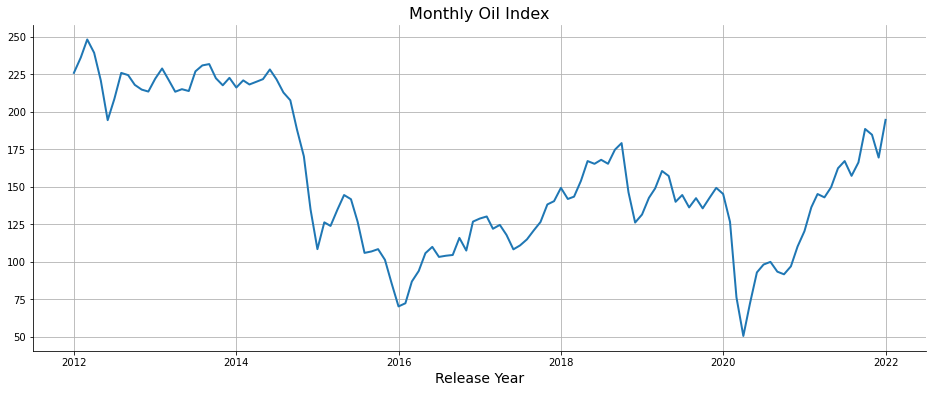

<Figure size 432x288 with 0 Axes>

In [5]:
plt.figure(figsize = (16,6))

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

plt.plot(df['Oil_index'], lw = 2)
plt.title('Monthly Oil Index', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.grid(True)
plt.figure()
plt.show()

<a name='5'></a>
## 5 - Statitstical tests

In [6]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("---------------------------------------------\n")
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("---------------------------------------------\n")
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

<a name='ex-1'></a>
### 5-1 Run the augmented Dickey-Fuller Test to confirm stationarity

In [7]:
adf_test(df['Oil_index'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.028450
p-value                   0.274240
# lags used               2.000000
# observations          118.000000
critical value (1%)      -3.487022
critical value (5%)      -2.886363
critical value (10%)     -2.580009
---------------------------------------------

Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


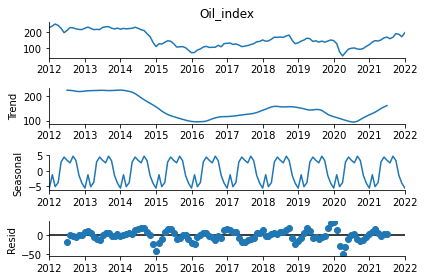

In [8]:
result = seasonal_decompose(df['Oil_index'], model='add')
result.plot();

#### Run the augmented Dickey-Fuller Test on the First Difference  

In [9]:
df['d1'] = diff(df['Oil_index'],k_diff=1)

# Equivalent to:
# df['d1'] = df['Oil_index'] - df['Oil_index'].shift(1)

adf_test(df['d1'],'Real Oil_index')

Augmented Dickey-Fuller Test: Real Oil_index
ADF test statistic     -8.000628e+00
p-value                 2.339241e-12
# lags used             1.000000e+00
# observations          1.180000e+02
critical value (1%)    -3.487022e+00
critical value (5%)    -2.886363e+00
critical value (10%)   -2.580009e+00
---------------------------------------------

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


This confirms that we reached stationarity after the first difference.
<a name='ex-2'></a>
### 5 - 2 Run the ACF and PACF plots
A <strong>PACF Plot</strong> can reveal recommended AR(p) orders, and an <strong>ACF Plot</strong> can do the same for MA(q) orders.<br>
Alternatively, we can compare the stepwise <a href='https://en.wikipedia.org/wiki/Akaike_information_criterion'>Akaike Information Criterion (AIC)</a> values across a set of different (p,q) combinations to choose the best combination.  

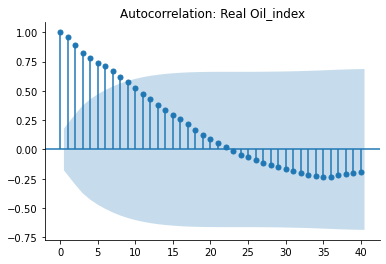

In [10]:
title = 'Autocorrelation: Real Oil_index'
lags = 40
plot_acf(df['Oil_index'],title=title,lags=lags);

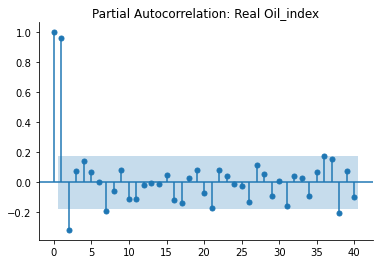

In [11]:
title = 'Partial Autocorrelation: Real Oil_index'
lags = 40
plot_pacf(df['Oil_index'],title=title,lags=lags);

<a name='6'></a>
## 6 - Time-series Models
---

<a name='ex-3'></a>
### 6 -1 SARIMAX - Seasonal Autoregressive Integrated Moving Average Exogenou

Let's take a look at <tt>pmdarima.auto_arima</tt> done stepwise to see if having $p$ and $q$ terms the same still makes sense:

In [12]:
stepwise_fit = auto_arima(df['Oil_index'], start_p=0, start_q=0,
                          max_p=4, max_q=4, m=12,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=949.294, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=939.292, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=934.303, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=947.347, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=932.384, Time=0.07 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=934.314, Time=0.15 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=936.092, Time=0.33 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=934.383, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=934.382, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=937.313, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=935.394, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=930.393, Time=0.03 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=932.326, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12]             

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  121
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -463.197
Date:                Fri, 22 Apr 2022   AIC                            930.393
Time:                        16:31:25   BIC                            935.968
Sample:                             0   HQIC                           932.657
                                - 121                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4228      0.088      4.805      0.000       0.250       0.595
sigma2       131.6872     13.641      9.654      0.000     104.952     158.423
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                12.63
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.49   Skew:                            -0.42
Prob(H) (two-sided):                  0.21   Kurtosis:                         4.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
# Alternativly we could check and verify automaticcaly orders with auto_arima
# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(df['Oil_index'], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  121
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -463.197
Date:                Fri, 22 Apr 2022   AIC                            930.393
Time:                        16:31:27   BIC                            935.968
Sample:                             0   HQIC                           932.657
                                - 121                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4228      0.088      4.805      0.000       0.250       0.595
sigma2       131.6872     13.641      9.654      0.000     104.952     158.423
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                12.63
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.49   Skew:                            -0.42
Prob(H) (two-sided):                  0.21   Kurtosis:                         4.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
##### Spilit data to train- and testset 

train = df[ :108]
test = df[108: ]

In [15]:
model = SARIMAX(train['Oil_index'],order=(0,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Oil_index   No. Observations:                  108
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -411.675
Date:                Fri, 22 Apr 2022   AIC                            827.350
Time:                        16:31:27   BIC                            832.696
Sample:                    01-01-2012   HQIC                           829.517
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4082      0.092      4.453      0.000       0.229       0.588
sigma2       128.4176     13.793      9.310      0.000     101.383     155.452
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                15.86
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.50   Skew:                            -0.57
Prob(H) (two-sided):                  0.23   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,1) Predictions')

# Compare predictions to expected values
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Oil_index'][i]}")

predicted=114.6487029, expected=120.320422223982
predicted=114.6487029, expected=136.26020107953653
predicted=114.6487029, expected=145.10139058412366
predicted=114.6487029, expected=142.87314612498395
predicted=114.6487029, expected=149.6528232235643
predicted=114.6487029, expected=162.28400207786768
predicted=114.6487029, expected=167.07551011026038
predicted=114.6487029, expected=157.22536986356013
predicted=114.6487029, expected=166.18058689112854
predicted=114.6487029, expected=188.4750012714206
predicted=114.6487029, expected=184.63902954157263
predicted=114.6487029, expected=169.4092247905264
predicted=114.6487029, expected=194.54896148005847


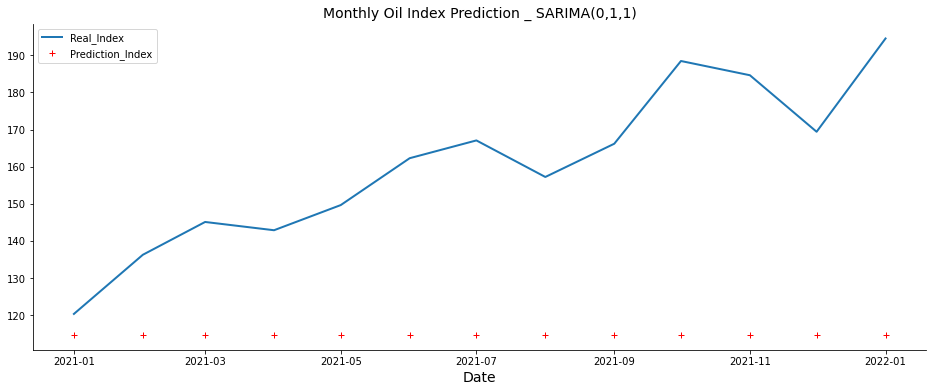

<Figure size 432x288 with 0 Axes>

In [17]:
plt.figure(figsize = (16,6))

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

plt.plot(test['Oil_index'], label='Real_Index', lw = 2)
plt.plot(predictions, 'r+', label='Prediction_Index', lw = 2)
plt.title('Monthly Oil Index Prediction _ SARIMA(0,1,1)', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend()
plt.figure()

plt.show()

In [18]:
error = mean_squared_error(test['Oil_index'], predictions)
print(f'SARIMA(0,1,1) Predictions MSE Error: {error:11.10}')

error = rmse(test['Oil_index'], predictions)
print(f'SARIMA(0,1,1) RMSE Error: {error:11.10}')

SARIMA(0,1,1) Predictions MSE Error: 2512.787137
SARIMA(0,1,1) RMSE Error: 50.12770828


<a name='ex-4'></a>
### 6 - 2 Time-Series Prediction Using RNN - LSTM

In [19]:
scaler = MinMaxScaler()
df = df[['Oil_index']]
train = df[ :108]
test = df[108: ]

In [20]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

#### Time Series Generator;

In [21]:
# define generator
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

#### Create The Model;

In [22]:
# define model
model = Sequential()
model.add(LSTM(128, input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(256))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 256)               394240    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 461,057
Trainable params: 461,057
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit_generator(generator,
                              epochs=50,
                              verbose = 1)

Epoch 1/50
96/96 [==============================] - 4s 19ms/step - loss: 0.0383
Epoch 2/50
96/96 [==============================] - 2s 19ms/step - loss: 0.0181
Epoch 3/50
96/96 [==============================] - 2s 18ms/step - loss: 0.0171
Epoch 4/50
96/96 [==============================] - 2s 19ms/step - loss: 0.0113
Epoch 5/50
96/96 [==============================] - 2s 18ms/step - loss: 0.0122
Epoch 6/50
96/96 [==============================] - 2s 18ms/step - loss: 0.0115
Epoch 7/50
96/96 [==============================] - 2s 18ms/step - loss: 0.0100
Epoch 8/50
96/96 [==============================] - 2s 18ms/step - loss: 0.0072
Epoch 9/50
96/96 [==============================] - 2s 18ms/step - loss: 0.0060
Epoch 10/50
96/96 [==============================] - 2s 18ms/step - loss: 0.0060
Epoch 11/50
96/96 [==============================] - 2s 18ms/step - loss: 0.0053
Epoch 12/50
96/96 [==============================] - 2s 18ms/step - loss: 0.0042
Epoch 13/50
96/96 [==================

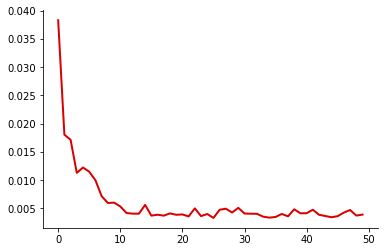

In [24]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch, color = '#db0000', lw = 2)

In [25]:
# model.save('my_rnn_model.h5')
# model = tf.keras.models.load_model('my_rnn_model.h5')

In [26]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
df = df.merge(test, how='outer', on='Oil_index')

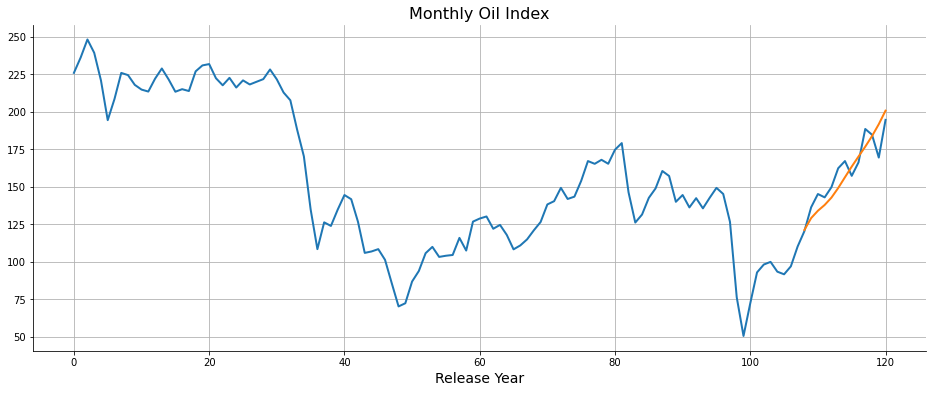

<Figure size 432x288 with 0 Axes>

In [27]:
plt.figure(figsize = (16,6))

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

plt.plot(df, lw = 2)
plt.title('Monthly Oil Index', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.grid(True)
plt.figure()
plt.show()

<a name='ex-5'></a>
### 6 - 3 Prophet Model

In [28]:
df = db[["Commodity", "POILAPSP"]].iloc[-121:]
df['Oil_index'] = df['POILAPSP'].astype('float')
df['Commodity'] = df['Commodity'].str.replace("M", "-") + '-1'
df['Date'] = pd.to_datetime(df['Commodity'])
df = df[['Date', 'Oil_index']]
df.columns = ['ds','y']
df

,ds,y
267,2012-01-01,225.891156
268,2012-02-01,236.120545
269,2012-03-01,248.161237
270,2012-04-01,239.280530
271,2012-05-01,220.830698
...,...,...
383,2021-09-01,166.180587
384,2021-10-01,188.475001
385,2021-11-01,184.639030
386,2021-12-01,169.409225


In [29]:
train = df.iloc[:108]
test = df.iloc[108:]

In [30]:
model_pr = Prophet()
model_pr.fit(train)
future = model_pr.make_future_dataframe(periods=12, freq='MS')
forcast = model_pr.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [31]:
forcast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
115,2021-08-01,110.224059,77.472623,152.604970,109.466661,110.815622,4.166115,4.166115,4.166115,4.166115,4.166115,4.166115,0.0,0.0,0.0,114.390174
116,2021-09-01,109.872949,79.837842,155.855711,108.936984,110.627889,5.930957,5.930957,5.930957,5.930957,5.930957,5.930957,0.0,0.0,0.0,115.803906
117,2021-10-01,109.533164,79.445845,150.637902,108.449671,110.417230,4.423759,4.423759,4.423759,4.423759,4.423759,4.423759,0.0,0.0,0.0,113.956923
118,2021-11-01,109.182053,72.708723,147.996958,107.923720,110.216870,0.076527,0.076527,0.076527,0.076527,0.076527,0.076527,0.0,0.0,0.0,109.258580
119,2021-12-01,108.842269,69.804395,144.591003,107.426932,110.041133,-1.041224,-1.041224,-1.041224,-1.041224,-1.041224,-1.041224,0.0,0.0,0.0,107.801045


In [32]:
test.tail()

,ds,y
383,2021-09-01,166.180587
384,2021-10-01,188.475001
385,2021-11-01,184.639030
386,2021-12-01,169.409225
387,2022-01-01,194.548961


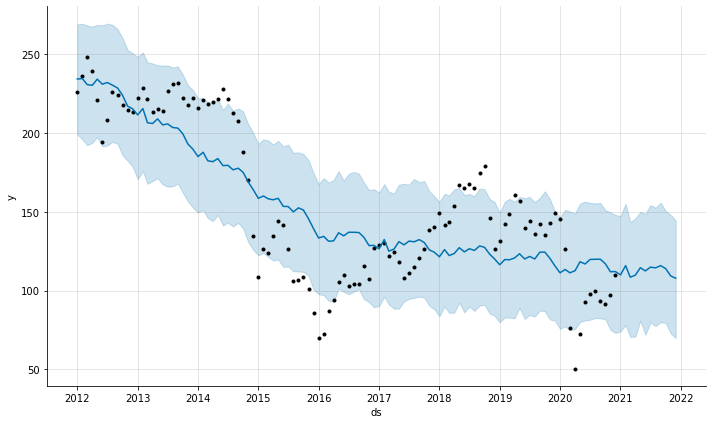

In [33]:
model_pr.plot(forcast);

<AxesSubplot:xlabel='ds'>

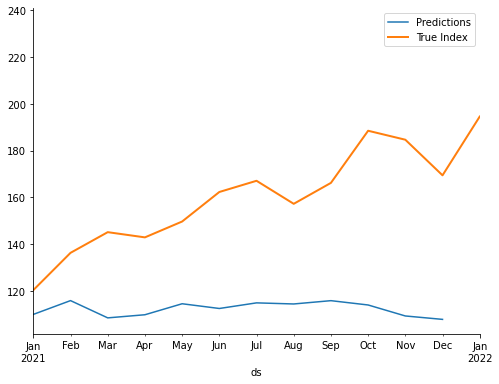

In [46]:
ax = forcast.plot(x='ds',y='yhat', label='Predictions',legend=True,figsize=(8,6))

test.plot(x='ds',y='y',label='True Index',legend=True,ax=ax,xlim=('2021-01-01','2022-01-01'), lw = 2)